In [1]:
import pandas as pd
import numpy as np
import re
from Bio.SeqUtils import gc_fraction
from Bio.SeqUtils.MeltingTemp import Tm_Wallace
from ViennaRNA import fold
import matplotlib.pyplot as plt
import matplotlib.patches as pat
from scipy.stats import pearsonr, spearmanr

In [2]:
def rc(dna_sequence):
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C',
                  'a': 't', 't': 'a', 'c': 'g', 'g': 'c',
                  'X': 'X', 'x': 'x'}
                       
    return ''.join([complement[nucleotide] for nucleotide in reversed(dna_sequence)])

In [3]:
def polyT(dna_sequence):
    if len(dna_sequence) == 0:
        return 0
    
    count = dna_sequence.count('T')
    
    return 100 * count / len(dna_sequence)

In [4]:
def find_lowercase_index(s):
    for i, c in enumerate(s):
        if c.islower():
            return i

In [5]:
def find_lowercase_length(s):
    length = 0
    for c in s:
        if c.islower():
            length += 1
        else:
            if length > 0:  # Break on the first uppercase
                break
    return length

In [6]:
def remove_flanking_x(s):
    return re.sub(r'^x+|x+$', '', s, flags=re.IGNORECASE)

In [58]:
features = ['DeepSpCas9', 'ED_pos', 'ED_len', 'type_sub', 'type_ins',
            'type_del', 'PBS_len', 'RTT_len', 'RHA_len', 'ext_len',
            'WTS_GC', 'PBS_GC', 'RTT_GC', 'RHA_GC', 'spacer_GC', 'ext_GC',
            'WTS_Tm', 'PBS_Tm', 'RTT_Tm', 'RHA_Tm', 'spacer_Tm', 'ext_Tm',
            'PBS_MFE', 'RTT_MFE', 'spacer_MFE', 'ext_MFE',
            'ext_U', 'protoS_U', 'E']

In [59]:
# DeepPE 43149+6152=49301
dp = pd.read_csv('./raw_data/DeepPE_lib1.csv') # lib1 +5G->C
# dp_pt = pd.read_csv('raw_data/DeepPE_lib2.csv') # lib2 position/type

cols = ['dataset', 'model', 'WTS', 'protoS', 'ext', 'PBS_len', 'RTT_len', 'ext_len',
        'ED', 'PBS_Tm', 'RTT_cor_Tm', 'rt_cDNA_Tm', 'RTT_Tm', 'delta_Tm',
        'PBS_GCc', 'RTT_GCc', 'ext_GCc', 'PBS_GC', 'RTT_GC', 'ext_GC',
        'peg_MFE', '-S_MFE', 'extT_MFE', 'protoS_MFE', 'protoSS_MFE', 'DeepSpCas9', 'E']
dp.columns = cols

In [60]:
# dp = dp.drop('ED', axis=1)
# cols.remove('ED')
# dp_pt.columns = cols

# dp_pt['type_sub'], dp_pt['type_ins'], dp_pt['type_del'] = None, None, None
# 
# dp_pt['ED_pos'] = dp_pt.apply(lambda row: find_lowercase_index(row['ext']), axis=1)
# dp_pt['ED_len'] = dp_pt.apply(lambda row: find_lowercase_length(row['ext']), axis=1)
# 
# dp_pt.drop('ext', axis=1)
# dp = pd.concat([dp, dp_pt])

In [61]:
dp['type_sub'], dp['type_ins'], dp['type_del'] = 1, 0, 0
dp['ED_pos'], dp['ED_len'] = 5, 1

dp['spacer'] = dp['protoS'].apply(rc)
dp['spacer_MFE'] = dp['spacer'].apply(fold)

dp['WTS_GC'], dp['spacer_GC'] = (dp['WTS'].apply(gc_fraction)*100, 
                                 dp['spacer'].apply(gc_fraction)*100)
dp['WTS_Tm'] = dp['WTS'].apply(Tm_Wallace)
dp['spacer_Tm'] = dp['spacer'].apply(Tm_Wallace)
dp['ext_Tm'] = dp['ext'].apply(Tm_Wallace)

dp['PBS'] = dp.apply(lambda row: rc(row['ext'][:row['PBS_len']]), axis=1)
dp['PBS_MFE'] = dp['PBS'].apply(fold)
dp['PBS_Tm'] = dp['PBS'].apply(Tm_Wallace)

dp['RTT'] = dp.apply(lambda row: rc(row['ext'][row['PBS_len']:]), axis=1)
dp['RTT_MFE'] = dp['RTT'].apply(fold)
dp['RTT_Tm'] = dp['RTT'].apply(Tm_Wallace)

dp['ext_MFE'] = dp['ext'].apply(fold)

dp['RHA'] = dp.apply(lambda row: rc(row['ext'][(row['PBS_len']+5):]), axis=1)
dp['RHA_len'] = dp['RHA'].str.len()
dp['RHA_GC'] = dp['RHA'].apply(gc_fraction)*100
dp['RHA_Tm'] = dp['RHA'].apply(Tm_Wallace)

dp['ext_U'] = dp['ext'].apply(polyT)
dp['protoS_U'] = dp['protoS'].apply(polyT)

dp = dp[features]

dp.to_csv('./raw_data/dp.csv')

In [62]:
# DeepPrime 288793, uses PE2
prime = pd.read_csv('./raw_data/DeepPrime_raw_data.csv')

cols = ['dataset', 'model', 'WTS', 'ED', 'PBS_len', 'RTT_len', 'ext_len',
        'ED_pos', 'ED_len', 'RHA_len', 'type_sub', 'type_ins', 'type_del',
        'PBS_Tm', 'RTT_cor_Tm', 'RTT_cor_Tm_new', 'rt_cDNA_Tm', 'RTT_Tm',
        'delta_Tm', 'PBS_GCc', 'RTT_GCc', 'ext_GCc', 'PBS_GC', 'RTT_GC',
        'ext_GC', 'ext_MFE', 'protoS_MFE', 'DeepSpCas9', 'E', 'fold']
prime.columns = cols

prime['WTS'] = prime['WTS'].str[:-27]
prime['protoS'] = prime['WTS'].str[4:24]

prime['spacer'] = prime['protoS'].apply(rc)
prime['spacer_MFE'] = prime['spacer'].apply(fold)

prime['spacer_GC'] = prime['spacer'].apply(gc_fraction)*100
prime['spacer_Tm'] = prime['spacer'].apply(Tm_Wallace)
prime['protoS_U'] = prime['protoS'].apply(polyT)

prime['WTS_GC'], prime['WTS_Tm'] = (prime['WTS'].apply(gc_fraction)*100, 
                                    prime['WTS'].apply(Tm_Wallace))

prime['ext'] = prime['ED'].apply(remove_flanking_x)
prime['ext'] = prime['ED'].apply(rc)
prime['ext_Tm'] = prime['ext'].apply(Tm_Wallace)
prime['ext_U'] = prime['ext'].apply(polyT)

prime['RTT'] = prime.apply(lambda row: rc(row['ext'][:row['RTT_len']]), axis=1)
prime['RTT_MFE'] = prime['RTT'].apply(fold)
prime['RTT_Tm'] = prime['RTT'].apply(Tm_Wallace)

prime['PBS'] = prime.apply(lambda row: rc(row['ext'][row['RTT_len']:]), axis=1)
prime['PBS_MFE'] = prime['PBS'].apply(fold)
prime['PBS_Tm'] = prime['PBS'].apply(Tm_Wallace)

prime['RHA'] = prime.apply(lambda row: row['ext'][-1*row['RHA_len']:], axis=1)
prime['RHA_GC'] = prime['RHA'].apply(gc_fraction)*100
prime['RHA_Tm'] = prime['RHA'].apply(Tm_Wallace)

prime = prime[features]

prime.to_csv('./raw_data/prime.csv')

/var/folders/_m/j48mn9812m961127xq723wmh0000gn/T/ipykernel_50787/3566263774.py:2: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  prime = pd.read_csv('./raw_data/DeepPrime_raw_data.csv')


In [63]:
# Mathis 92423+1938=94361, library 2 with tevopreQ1 (don't use)
pridict = pd.read_csv('./raw_data/mathis_lib1.csv')

pridict['ext_len'] = pridict['PBSlength'] + pridict['RTlength']
pridict['type_sub'] = np.where(pridict['Correction_Type'] == 'Replacement', 1, 0)
pridict['type_ins'] = np.where(pridict['Correction_Type'] == 'Insertion', 1, 0)
pridict['type_del'] = np.where(pridict['Correction_Type'] == 'Deletion', 1, 0)

pridict['wide_initial_target'] = pridict['wide_initial_target'].str[6:-46]

pridict['WTS_Tm'] = pridict['wide_initial_target'].apply(Tm_Wallace)
pridict['PBS_Tm'] = pridict['PBS_seq'].apply(Tm_Wallace)
pridict['RTT_Tm'] = pridict['RT_seq'].apply(Tm_Wallace)

pridict['protoS'] = pridict['wide_initial_target'].str[10:29]
pridict['spacer'] = pridict['protoS'].apply(rc)
pridict['spacer_Tm'] = pridict['spacer'].apply(Tm_Wallace)
pridict['spacer_MFE'] = pridict['spacer'].apply(fold)

pridict['ext_U'] = pridict['Extension_seq'].apply(polyT)
pridict['protoS_U'] = pridict['protoS'].apply(polyT)
pridict['RHA_GC'] = pridict['RToverhang_seq'].apply(gc_fraction)*100
pridict['WTS_GC'] = pridict['wide_initial_target'].apply(gc_fraction)*100

pridict = pridict[['deepcas9', 'Editing_Position', 'Correction_Length',
                   'type_sub', 'type_ins', 
                   'type_del', 'PBSlength','RTlength', 'RToverhanglength', 'ext_len',  
                   'WTS_GC', 'PBS_GC_content',
                   'RT_GC_content', 'RHA_GC', 'Proto_GC_content', 'Extension_GC_content',
                   'WTS_Tm', 'PBSmt', 'RTmt', 'RToverhangmt', 'spacer_Tm',
                   'extensionmt',
                   'MFE_pbs', 'MFE_rt', 'spacer_MFE', 'MFE_extension',
                   'ext_U', 'protoS_U', 'averageedited']]

pridict.columns = features
pridict.to_csv('./raw_data/pridict.csv')

In [64]:
pridict_two = pd.read_csv('./raw_data/mathis2_library_diverse.csv')

pridict_two['ext_len'] = pridict_two['PBSlength'] + pridict_two['RTlength']
pridict_two['type_sub'] = np.where(pridict_two['Correction_Type'] == 'Replacement', 1, 0)
pridict_two['type_ins'] = np.where(pridict_two['Correction_Type'] == 'Insertion', 1, 0)
pridict_two['type_del'] = np.where(pridict_two['Correction_Type'] == 'Deletion', 1, 0)

pridict_two['wide_initial_target'] = pridict_two['wide_initial_target'].str[6:-46]
pridict_two['WTS_Tm'] = pridict_two['wide_initial_target'].apply(Tm_Wallace)

pridict_two['ext_U'] = pridict_two['Extension_seq'].apply(polyT)
pridict_two['protoS'] = pridict_two['spacer'].apply(rc)
pridict_two['protoS_U'] = pridict_two['protoS'].apply(polyT)

pridict_two['RHA_GC'] = pridict_two['RTToverhang'].apply(gc_fraction)*100
pridict_two['WTS_GC'] = pridict_two['wide_initial_target'].apply(gc_fraction)*100

pridict_two['spacer_MFE'] = pridict_two['spacer'].apply(fold)

pridict_two = pridict_two[['deepcas9', 'Editing_Position', 'Correction_Length',
                   'type_sub', 'type_ins',
                   'type_del', 'PBSlength','RTlength', 'RToverhanglength', 'ext_len',
                   'WTS_GC', 'PBS_GC_content',
                   'RT_GC_content', 'RHA_GC', 'Spacer_GC_content', 'Extension_GC_content',
                   'WTS_Tm', 'PBSmt', 'RTmt', 'RTToverhangmt', 'spacermt',
                   'extensionmt',
                   'MFE_pbs', 'MFE_rt', 'spacer_MFE', 'MFE_extension',
                   'ext_U', 'protoS_U', 'HEKaverageedited']]
pridict_two.columns = features
pridict_two['E'] = pridict_two['E'].fillna(0)
pridict_two.to_csv('./raw_data/pridict_2.csv')

/var/folders/_m/j48mn9812m961127xq723wmh0000gn/T/ipykernel_50787/4054481879.py:1: DtypeWarning: Columns (99) have mixed types. Specify dtype option on import or set low_memory=False.
  pridict_two = pd.read_csv('./raw_data/mathis2_library_diverse.csv')


In [2]:
dp, prime, pridict, pridict_two = (pd.read_csv('./raw_data/dp.csv'),
                                   pd.read_csv('./raw_data/prime.csv'),
                                   pd.read_csv('./raw_data/pridict.csv'),
                                   pd.read_csv('./raw_data/pridict_2.csv'))

dp['PBS_MFE'] = dp['PBS_MFE'].str.extract('(-?\d+\.\d+)')
dp['RTT_MFE'] = dp['RTT_MFE'].str.extract('(-?\d+\.\d+)')
dp['ext_MFE'] = dp['ext_MFE'].str.extract('(-?\d+\.\d+)')

prime['PBS_MFE'] = prime['PBS_MFE'].str.extract('(-?\d+\.\d+)')
prime['RTT_MFE'] = prime['RTT_MFE'].str.extract('(-?\d+\.\d+)')

print(dp['E'].mean())
print(prime['E'].mean())
print(pridict['E'].mean())
print(pridict_two['E'].mean())
print(dp.shape[0] + prime.shape[0] + pridict.shape[0] + pridict_two.shape[0])

9.57816166680634
2.182648937695214
41.42459088179817
27.71990643156534
447321


In [4]:
df = pd.concat([dp, prime, pridict, pridict_two])
df['spacer_MFE'] = df['spacer_MFE'].str.extract('(-?\d+\.\d+)')

df = df.loc[df['E']>=0]

print(df.shape[0])

df_shuffled = df.sample(frac=1).reset_index(drop=True)
df_shuffled.drop('Unnamed: 0', axis=1, inplace=True)
# 
# train, validate, test = np.split(df_shuffled, [int(0.7*len(df_shuffled)), int(0.85*len(df_shuffled))])
# 
# train.to_csv('./processed_data/train.csv')
# validate.to_csv('./processed_data/validate.csv')
# test.to_csv('./processed_data/test.csv')

446243


In [68]:
df_shuffled

,DeepSpCas9,ED_pos,ED_len,type_sub,type_ins,type_del,PBS_len,RTT_len,RHA_len,ext_len,...,RHA_Tm,spacer_Tm,ext_Tm,PBS_MFE,RTT_MFE,spacer_MFE,ext_MFE,ext_U,protoS_U,E
0,40.347275,26,3,0,1,0,10,36,8,46,...,0.0,66.0,142.0,-2.200000047683716,0.0,-1.7999999523162842,-12.2,18.918919,25.000000,0.258732
1,70.152237,10,1,0,1,0,11,15,5,26,...,0.0,66.0,90.0,-3.5,0.0,-4.900000095367432,-5.1,5.405405,10.000000,5.090909
2,37.935577,5,1,0,1,0,13,16,11,29,...,10.0,66.0,98.0,-8.800000190734863,0.0,-6.699999809265137,-7.2,6.756757,15.000000,11.649072
3,54.988319,6,1,1,0,0,16,14,8,30,...,10.0,68.0,92.0,-1.2000000476837158,0.0,-3.200000047683716,-4.2,13.513514,5.000000,4.218600
4,38.965000,5,1,1,0,0,9,10,5,19,...,18.0,68.0,66.0,0.0,0.0,-4.0,-2.0999999046325684,26.315789,25.000000,4.304905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446238,41.018185,2,1,1,0,0,10,2,0,12,...,42.0,68.0,42.0,-1.2000000476837158,0.0,-3.4000000953674316,-1.6,2.702703,5.000000,0.254547
446239,20.358000,5,1,1,0,0,15,10,5,25,...,20.0,62.0,80.0,-2.299999952316284,0.0,-2.299999952316284,-1.7000000476837158,32.000000,35.000000,4.770935
446240,17.852745,20,1,0,0,1,12,22,3,34,...,0.0,72.0,114.0,-6.5,0.0,-4.400000095367432,-7.9,9.459459,10.000000,0.000000
446241,43.951000,5,1,1,0,0,13,15,10,28,...,32.0,62.0,90.0,0.0,-0.699999988079071,-0.8999999761581421,-0.6000000238418579,28.571429,25.000000,1.134393


In [193]:
# combined_e = pd.concat([dp['E'], prime['E'], pridict['E'], pridict_two['E']])
# 
# min_e, max_e = combined_e.min(), combined_e.max()
# bins = np.linspace(min_e, max_e, 21) 
# 
# dp['E_bin'] = pd.cut(dp['E'], bins=bins, include_lowest=True, labels=False)
# prime['E_bin'] = pd.cut(prime['E'], bins=bins, include_lowest=True, labels=False)
# pridict['E_bin'] = pd.cut(pridict['E'], bins=bins, include_lowest=True, labels=False)
# pridict_two['E_bin'] = pd.cut(pridict_two['E'], bins=bins, include_lowest=True, labels=False)
# 
# final_df = equalize_bins_without_replacement([dp, prime, pridict, pridict_two])
# 
# final_df['spacer_MFE'] = final_df['spacer_MFE'].str.extract('(-?\d+\.\d+)')
# 
# df_shuffled = final_df.sample(frac=1).reset_index(drop=True)
# df_shuffled.drop(columns=['Unnamed: 0', 'E_bin'], inplace=True)
# 
# train, validate, test = np.split(df_shuffled, [int(0.7*len(df_shuffled)), int(0.85*len(df_shuffled))])
# 
# train.to_csv('./processed_data/train.csv')
# validate.to_csv('./processed_data/validate.csv')
# test.to_csv('./processed_data/test.csv')

\\
\\
\\

In [ ]:
plt.figure(figsize=(10,5))
# distribution = np.where(prime['E'] == 0, 1e-6, prime['E'])
# distribution = 1 / np.sqrt(distribution)

n, bins, patches = plt.hist(df['E'], bins=10, color='midnightblue', density=True)

plt.title('Distribution of pegRNA Efficiencies', fontsize=20)
plt.xlabel('Efficiency', fontsize=20)
plt.ylabel('Proportion', fontsize=20)
plt.xticks()

for i in range(len(n)):
    plt.text(bins[i]+((bins[i+1]-bins[i])/2), n[i], f'{n[i]:.4f}', ha='center', va='bottom')

plt.show()

In [ ]:
# Bin the 'RHA_len' data in intervals of 10
bin_size = 5
bins = np.arange(df_shuffled['RHA_Tm'].min(), df_shuffled['RHA_Tm'].max() + bin_size, bin_size)
df_shuffled['binned'] = pd.cut(df_shuffled['RHA_Tm'], bins, right=False)

# Calculate the average 'E' for each bin
binned_data = df_shuffled.groupby('binned')['E'].mean().reset_index()

# Extract the mid point of the bins to use as x labels
binned_data['mid'] = bins[:-1] + bin_size / 2

# Plotting
plt.bar(binned_data['mid'], binned_data['E'], width=bin_size * 0.9)
plt.ylabel('Average Efficiency', fontsize=20)
plt.xlabel('RHA Melting Temperature (K)', fontsize=20)
r_value, _ = pearsonr(df_shuffled['RHA_Tm'], df_shuffled['E'])
plt.title(f'Average Efficiency vs RHA_Tm (r = {r_value:.2f})')
plt.show()

In [ ]:
df_indel = df[(df['type_ins']==1) | (df['type_del']==1)]


In [ ]:
freq_sub = df_shuffled['type_sub'].sum()
freq_del = df_shuffled['type_del'].sum()
freq_ins = df_shuffled['type_ins'].sum()

labels = ['Substitution', 'Deletion', 'Insertion']
sizes = [freq_sub, freq_del, freq_ins]

# Create pie chart
plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * sum(sizes) / 100, p),
        startangle=90, wedgeprops=dict(edgecolor='black'))
plt.axis('equal')
plt.title('Distribution of pegRNA Edit Types')
plt.show()

In [ ]:
df_melted = df_shuffled.melt(id_vars=['E'], value_vars=['type_sub', 'type_ins', 'type_del'], var_name='Type', value_name='Value')
df_filtered = df_melted[df_melted['Value'] == 1]
# TODO: adjust these efficiencies
df_del = df_shuffled[df_shuffled['type_del']==1]
# df_del = df_del[df_del['ED_len']>3]

df_ins = df_shuffled[df_shuffled['type_ins']==1]
# df_ins = df_ins[df_ins['ED_len']>3]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
ax_flat = axs.flatten()

boxplot_del = axs[0].boxplot([df_del[df_del['ED_len'] == length]['E'] for length in sorted(df_del['ED_len'].unique())],
                      labels=sorted(df_del['ED_len'].unique()), sym='')

boxplot_ins = axs[1].boxplot([df_ins[df_ins['ED_len'] == length]['E'] for length in sorted(df_ins['ED_len'].unique())],
                          labels=sorted(df_ins['ED_len'].unique()), sym='')

x_labels = ['Deletion Length', 'Insertion Length']
fig_labels = ['(a)', '(b)']
axs[0].set_ylabel('Adj. Efficiency', fontsize=20)

for i, a in enumerate(ax_flat):
    a.set_title(fig_labels[i])
    a.set_xlabel(x_labels[i], fontsize=20)
    a.grid(True)
    a.tick_params(labelsize=10)

plt.suptitle('Distribution of pegRNA Efficiencies by Edit Length', fontsize=20)
plt.show()

In [ ]:

mean_prime = prime['E'].mean()
mean_pridict = pridict['E'].mean()

adjustment = mean_pridict - mean_prime
prime['E'] += adjustment

df_hm = pd.concat([prime, pridict])
grouped_df = df_hm.groupby('ED_pos')['E'].mean().reset_index()
heatmap_data = np.full((1, 30), np.nan)  # Adjust size to include extra position

# Populate the heatmap data
for _, row in grouped_df.iterrows():
    position_index = int(row['ED_pos'])  # Assuming 'ED_pos' starts from 1
    if position_index < 30:  # Ensure we don't go beyond the new limit
        heatmap_data[0, position_index] = row['E']

plt.figure(figsize=(10, 2))
plt.imshow(heatmap_data, aspect='auto', cmap='plasma', origin='lower')

cbar = plt.colorbar()
cbar.set_label('Adj. Efficiency', fontsize=12)

plt.xticks(ticks=np.arange(30), labels=np.arange(1, 31))
plt.title('Distribution of pegRNA Efficiencies by Edit Position')
plt.xlabel('Edit Position (Relative to Nick Site)', fontsize=12)
plt.yticks([])
plt.show()


In [ ]:
df_sub = df_shuffled[df_shuffled['type_sub']==1]
df_ins = df_shuffled[df_shuffled['type_ins']==1]
df_del = df_shuffled[df_shuffled['type_del']==1]

print(df_sub['E'].mean(), df_ins['E'].mean(), df_del['E'].mean())

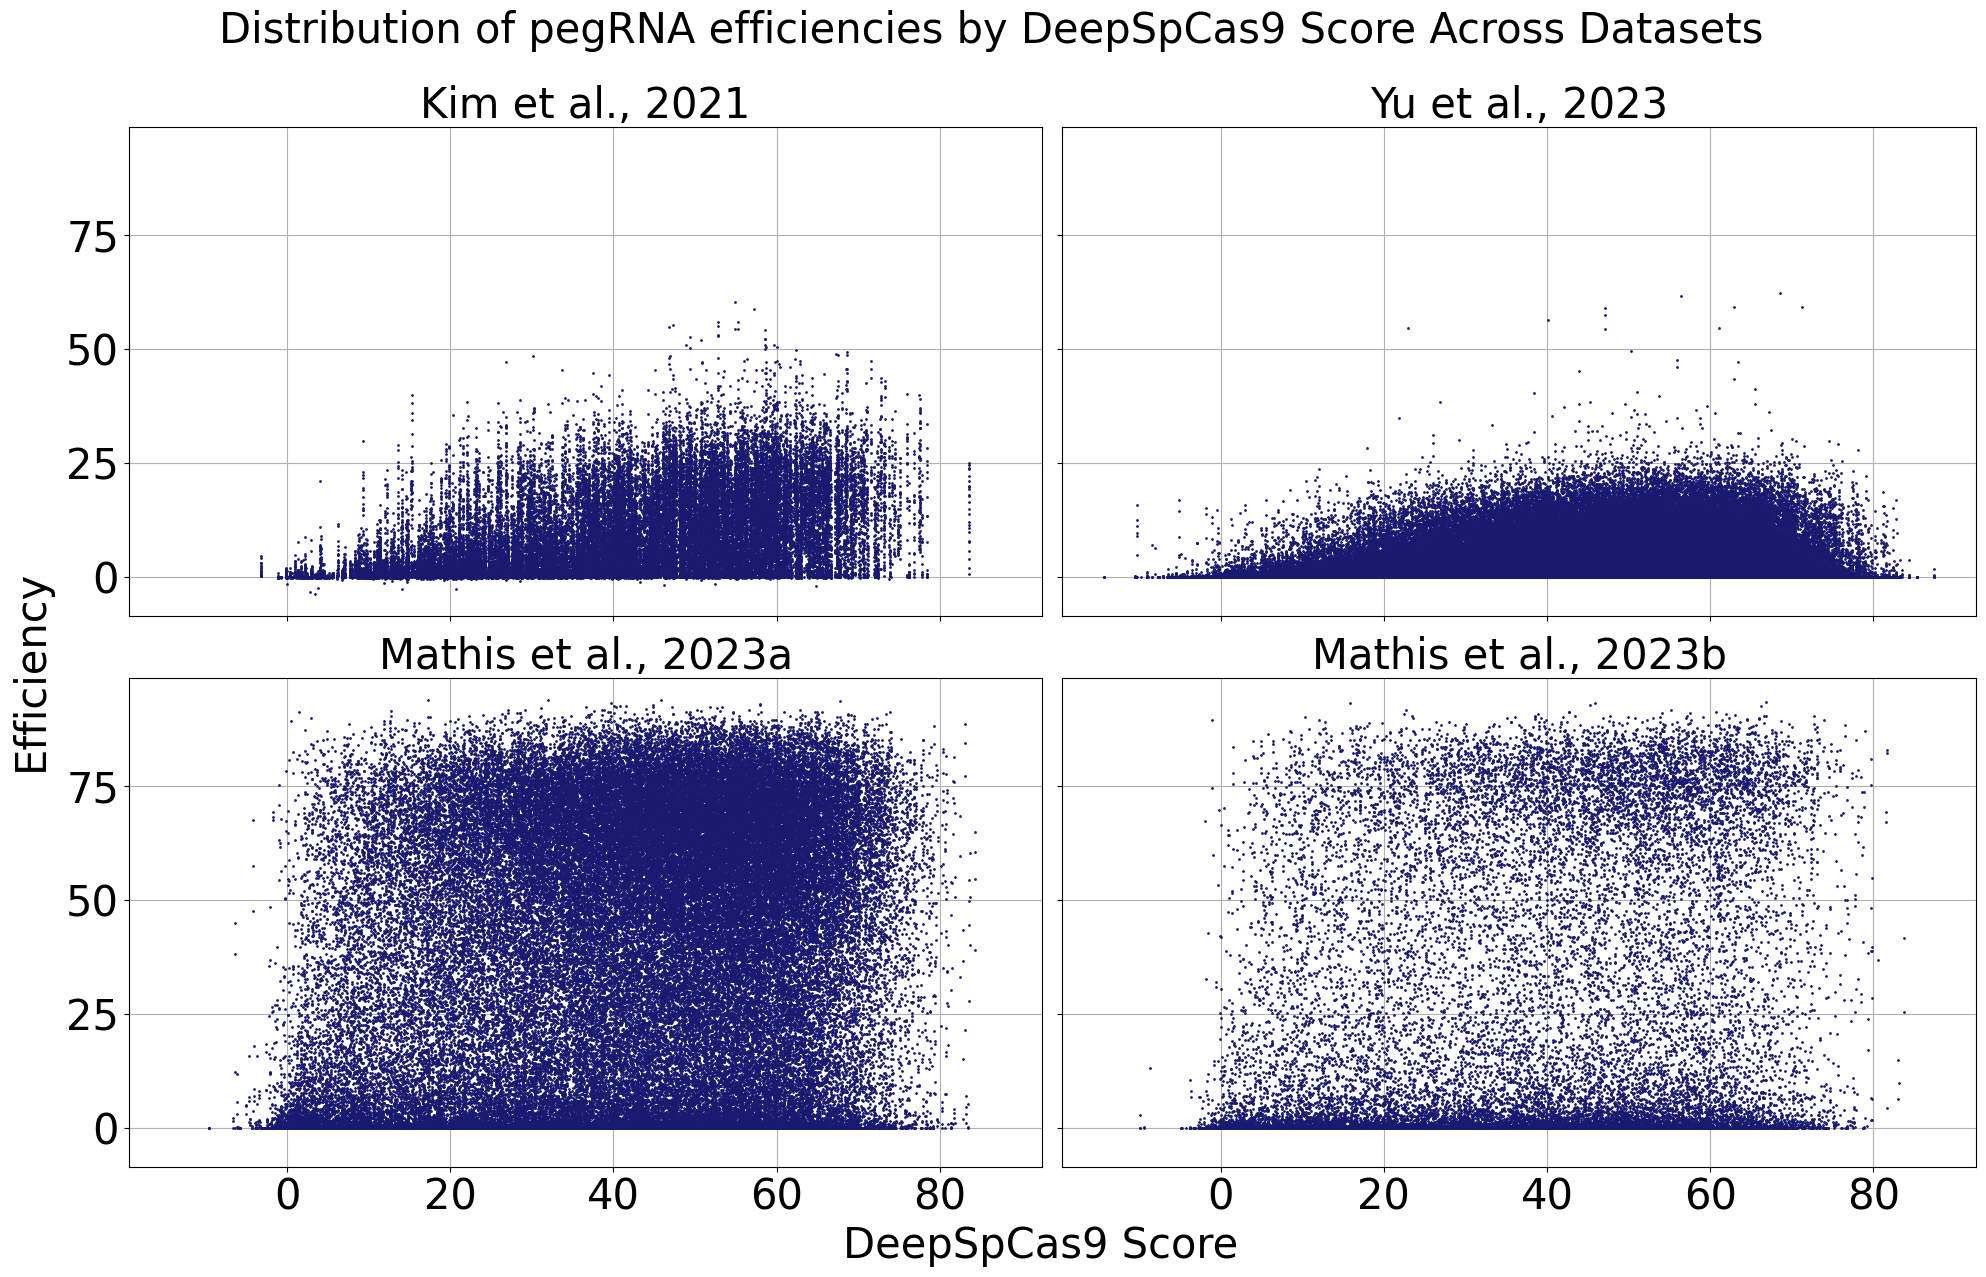

In [46]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12), sharex=True, sharey=True)

# Flatten the axes array for easy iteration
ax_flat = axs.flatten()

# Titles for each subplot
titles = ['Kim et al., 2021', 'Yu et al., 2023', 'Mathis et al., 2023a', 'Mathis et al., 2023b']

# DataFrames in a list for easy iteration
dataframes = [dp, prime, pridict, pridict_two]

for ax, df, title in zip(ax_flat, dataframes, titles):
    ax.set_axisbelow(True)
    ax.grid(True)
    ax.scatter(df['DeepSpCas9'], df['E'], s=1, c='midnightblue')
    ax.set_title(title, fontsize=30)
    ax.tick_params(labelsize=30)

# Set common labels
fig.text(0.525, 0.02, 'DeepSpCas9 Score', ha='center', va='center', fontsize=30)
fig.text(0.02, 0.5, 'Efficiency', ha='center', va='center', rotation='vertical', fontsize=30)

plt.tight_layout(rect=[0.03, 0.03, 1, 1])
plt.suptitle('Distribution of pegRNA efficiencies by DeepSpCas9 Score Across Datasets', y=1.05, fontsize=30)
plt.show()